# Beauty Classifier


In [3]:
# !pip install wget

  Running setup.py bdist_wheel for wget ... done
  Stored in directory: /home/ubuntu/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Setup and Helpers

In [5]:
# Imports
%run ../src/utils/helpers.py

from collections import defaultdict
import requests
import boto3
import tempfile
import wget

import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from IPython.display import Image, display, clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [6]:
# Initialization
s3_client = boto3.client('s3')
s3 = boto3.resource('s3')
s3_resource = boto3.resource('s3')
bucket_name = 'eye-of-the-needle'
bucket = s3.Bucket(bucket_name)

Records loaded. 1186 out of 3216 photos have been labeled stunning.

Displaying images scored 0:
['2018/04/24/2018_0424_152000/thumbnail.jpg']


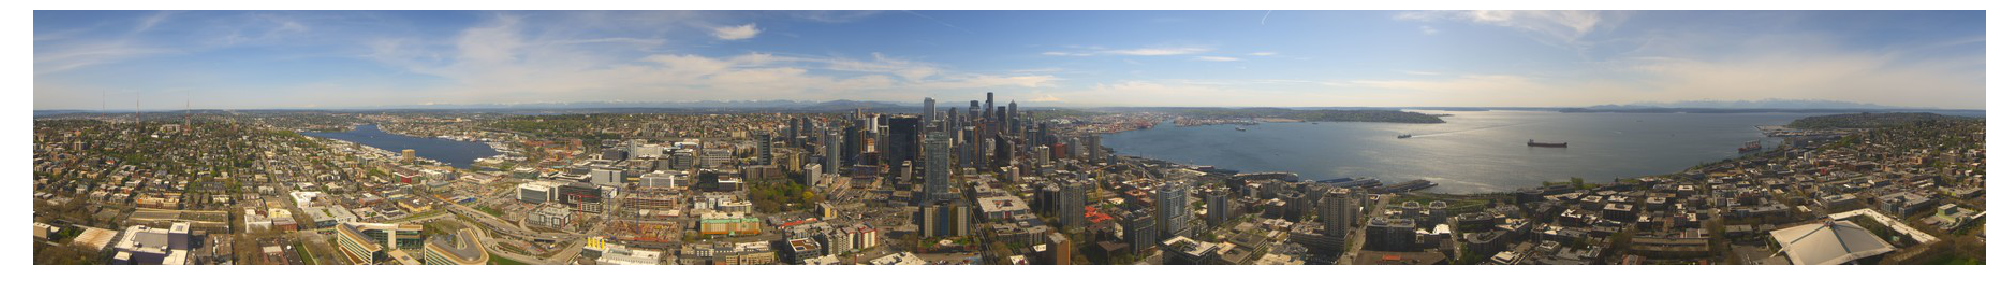

In [7]:
# Helper functions
record_path = '../data/raw/record.pkl'

@load_or_make(record_path, overwrite='n')
def get_record():
    record = defaultdict(dict)
    return record


def display_images(n, score=1):
    record = get_record()
    scores = sum(v['score'] for k, v in record.items())
    print(f"Records loaded. {scores} out of {len(record.keys())} photos have been labeled stunning.")
    l = list(record.keys())

    n_files = []
    while len(n_files) < n:
        f = random.choice(l)
        if record[f]['score'] == score:
            n_files.append(f)

    print(f"\nDisplaying images scored {score}:")
    print(n_files)
    fig = plt.figure(figsize=(35, 12))
    for i, file in enumerate(n_files):
        obj = bucket.Object(file)
        tmp = tempfile.NamedTemporaryFile()
        with open(tmp.name, 'wb') as f:
            obj.download_fileobj(f)
            img=mpimg.imread(tmp.name)
        ax = fig.add_subplot(n, 1, i + 1) 
        ax.imshow(img)
        ax.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    # plt.show()
    return img
n = 1
img = display_images(n, 0)

In [ ]:
from IPython.display import Image

fn = '../data/interim/_1130_4528215.png'
display(Image(filename=fn) )

In [5]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

pil_im = Image.open(fn) #Take jpg + png
## Uncomment to open from URL
#import requests
#r = requests.get('https://www.vegvesen.no/public/webkamera/kamera?id=131206')
#pil_im = Image.open(BytesIO(r.content))
im_array = np.asarray(pil_im)
plt.imshow(im_array)
plt.show()

OSError: cannot identify image file '../data/interim/_1130_4528215.png'

In [8]:
img.shape

(237, 1820, 3)

# Prep Data

In [12]:
import boto3
import os
from PIL import Image
from sklearn.model_selection import train_test_split


s3_client = boto3.client('s3')
s3_resource = boto3.resource('s3')

def clean_data(data):
    local_files = os.listdir("../data/imgs/")
    bad_files = []
    for file in data['filename']:
        im = Image.open('../data/imgs/' + file)
        shape = np.array(im).shape
        if shape != (237, 1820, 3):
            bad_files.append(file)
            print(f'{file} is wrong shape! Deleting!')
    for file in bad_files:
        data = data[data['filename'] != file]
    return data
    
    
def download_from_s3(prefix, local_path, bucket=bucket_name, client=s3_client, resource=s3_resource):
    keys = []
    dirs = []
    next_token = ''
    base_kwargs = {
        'Bucket': bucket_name,
        'Prefix': prefix,
    }
    while next_token is not None:
        kwargs = base_kwargs.copy()
        if next_token != '':
            kwargs.update({'ContinuationToken': next_token})
        results = s3_client.list_objects_v2(**kwargs)
        contents = results.get('Contents')
        for i in contents:
            k = i.get('Key')
            if k[-1] != '/':
                keys.append(k)
            else:
                dirs.append(k)
        next_token = results.get('NextContinuationToken')
    for d in dirs:
        dest_pathname = os.path.join(local, d)
        if not os.path.exists(os.path.dirname(dest_pathname)):
            os.makedirs(os.path.dirname(dest_pathname))
    for k in keys:
        if not os.path.exists(os.path.dirname(local_path)):
            os.makedirs(os.path.dirname(local_path))
        resource.meta.client.download_file(bucket, k, local_path)
    return


def get_files(data, path):
    local_files = set(os.listdir("../data/imgs/"))
    target_files = set(data['filename'])
    missing = target_files.difference(local_files)
    needed = data[data['filename'].isin(missing)]
    
    new_files = 0
    if len(needed) > 0:
        print(f'Getting {len(missing)} files from S3...')
        needed.apply(lambda x: download_from_s3(x['filepath'], path + x['filename']), axis=1)
        print('Success!\n')
        new_files = 1
        
    return new_files


def process_df(df):
    parse = lambda x: ''.join(x.split('/')[3].split('_'))[:-2]
    date_strings = df['index'].apply(parse)
    filenames = date_strings + 'thumb.jpg'
    df['filename'] = filenames

    df['date'] = pd.to_datetime(date_strings, format='%Y%m%d%H%M', errors='ignore')
    df = df.set_index(pd.DatetimeIndex(df['date'])).drop('date', axis=1)
    df = df.rename(columns={'index': 'filepath'})
    save_to(df, '../data/interim/data.pkl')
    
    df['target'] = df.apply(lambda x: ['fine', 'beautiful'][x['score']], axis=1)
#     df = pd.concat((df, pd.get_dummies(df['target'])), axis=1)
    return df


def get_df_from_record():
    record = get_record()
    df = pd.DataFrame.from_dict(record, orient='index').reset_index().sort_values(by='index')
    save_to(df, '../data/raw/df.pkl')
    return df


def run():
    path = '../data/imgs/'
    if 'imgs' not in os.listdir('../data/'):
        os.mkdir('../data/imgs')
    
    df = get_df_from_record()
    data = process_df(df)
    new_files = get_files(data, path)
#     if new_files:
    data = clean_data(data)
        
    train, test = train_test_split(data, test_size=0.2, random_state=42)
    train, val = train_test_split(train, test_size=0.2, random_state=42)
    
    save_to(train, '../data/interim/train.pkl')
    save_to(val, '../data/interim/val.pkl')
    save_to(test, '../data/interim/test.pkl')
    
    proportion = lambda x: x['score'].sum() / x.shape[0]
    msg = lambda x: f'{x.shape[0]} images with {round(100 * proportion(x), 2)}% positive class.'
    print(f'\nTrain set has {msg(train)}')
    print(f'Val set has {msg(val)}')
    print(f'Test set has {msg(test)}\n')
    
    
    
    return data

In [13]:
data = run()

Saved file to ../data/raw/df.pkl
Saved file to ../data/interim/data.pkl
201806280510thumb.jpg is wrong shape! Deleting!
201806282130thumb.jpg is wrong shape! Deleting!
201810070650thumb.jpg is wrong shape! Deleting!
Saved file to ../data/interim/train.pkl
Saved file to ../data/interim/val.pkl
Saved file to ../data/interim/test.pkl

Train set has 2056 images with 36.38% positive class.
Val set has 514 images with 40.66% positive class.
Test set has 643 images with 35.61% positive class.



In [14]:
len(data)

3213

In [14]:
from PIL import Image

local_files = os.listdir("../data/imgs/")
for file in local_files:
    im = Image.open('../data/imgs/' + file)
    shape = np.array(im).shape
    if shape != (237, 1820, 3):
        print(file, shape)

201806280510thumb.jpg (13958, 1820, 3)
201810070650thumb.jpg (13958, 1820, 3)
201806282130thumb.jpg (13958, 1820, 3)


In [116]:
from sklearn.model_selection import KFold
    
kf = KFold(n_splits=5, random_state=True) # Define the split - into 2 folds 
splits = kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator


## Extract features from convolutional base

We want to use a solution based on pre-trained models. We will use models that are composed of two parts:

* Convolutional base.
* Classifier.

Our approach will use the convolutional base to extract features, using them to train a classifier to classify the input image as beautiful or not. Therefore, the features extracted from the convolutional base will be the same for all classifiers studied in this example.

Now let's see how to extract features from a convolutional base.

In [21]:
# Imports
import os, shutil, sys
from time import time
import matplotlib as plt

from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.applications.imagenet_utils import decode_predictions
from keras import backend as k

from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception


In [22]:
def visualize_training(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    return

    
def get_datagen(data, set_name, img_height, img_width, batch_size):
    datagen = ImageDataGenerator(rescale=1. / 255)
    generator = datagen.flow_from_dataframe(dataframe=data,
                                            directory='../data/imgs/', 
                                            x_col='filename', 
                                            y_col='target', 
                                            target_size=(img_height, img_width),
                                            classes=['fine', 'beautiful'],
                                            class_mode='categorical', 
                                            batch_size=batch_size)
    return generator


def extract_features(img_height, img_width, conv_base, model_name, batch_size=32):
    # Params
    nb_epoch = 50
    base_model_last_block_layer_number = 126 # based on number of layers in base model (was 126)
    
    # Top Model Block
    x = conv_base.output
    x = GlobalAveragePooling2D()(x)
#     x = Dense(1024, activation='relu')(x)
    x = Dropout(rate=0.2)(x)
#     predictions = Dense(1, activation='nadam')(x)
    predictions = Dense(2, activation='softmax')(x)

    # add your top layer block to your base model
    model = Model(conv_base.input, predictions)
#     print('Model summary:')
#     print(model.summary())

    # Visualize layer names and layer indices to see how many layers/blocks to re-train
    # uncomment when choosing based_model_last_block_layer
#     print('Visualizing layer names and indices to see how many layers/blocks to re-train.\n Use to choose base model last block layer.')
#     for i, layer in enumerate(model.layers):
#         print(i, layer.name)

    for layer in model.layers:
        layer.trainable = False

    # Read data and get generators
    train, val, test = get_data()

    train_generator = get_datagen(train, 'train', img_height, img_width, batch_size)
    val_generator = get_datagen(val, 'val', img_height, img_width, batch_size)
    
#     lr = 1e-4  # sgd learning rate
    lr = 1e-4  # sgd learning rate
    momentum = .9  # sgd momentum to avoid local minimum
    model.compile(optimizer=SGD(lr=lr, momentum=momentum, decay=0.0, nesterov=False, clipvalue=0.5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'], 
#                   clipvalue=0.5
                 )
#     model.compile(optimizer='nadam',
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])

    # Save weights of best training epoch: monitor either val_loss or val_acc
    model_path = f'../models/{model_name}/'
    os.makedirs(model_path, exist_ok=True)
    top_weights_path = f'{model_path}top_model_weights.h5'
    callbacks_list = [
        ModelCheckpoint(top_weights_path, monitor='val_acc', verbose=2, save_best_only=True),
        EarlyStopping(monitor='val_acc', patience=5, verbose=0)
    ]
    
    # Train Simple CNN
#     f = 0.5
#     weight = {0: f * train['score'].value_counts()[1] / train['score'].sum(), 1: 1.}
    model.fit_generator(train_generator,
                        steps_per_epoch=np.ceil(len(train) / batch_size),
                        epochs=nb_epoch / 5,
                        validation_data=val_generator,
                        validation_steps=np.ceil(len(val) / batch_size),
                        verbose=1,
#                         class_weight=weight,
                        callbacks=callbacks_list,
                        use_multiprocessing=True)
    
    # Verbose
    print("\nStarting to fine tune model. Training back to layer {base_model_last_block_layer_number}\n")
    model.load_weights(top_weights_path)

    for layer in model.layers[:base_model_last_block_layer_number]:
        layer.trainable = False
    for layer in model.layers[base_model_last_block_layer_number:]:
        layer.trainable = True

    # Compile the model with a SGD/momentum optimizer
    # and a very slow learning rate.
    model.compile(optimizer=SGD(lr=lr, momentum=momentum, decay=0.0, nesterov=False, clipvalue=0.5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'], 
#                   clipvalue=0.5
                 )
#     model.compile(optimizer='nadam',
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])
    
    # Start up Tensorboard for visualization
    print('\nStarting Tensorboard: run the following in terminal:')
    print(f'\ttensorboard --logdir={model_path}logs/\n')
    tensorboard = TensorBoard(log_dir=f"{model_path}logs/{time()}")

    # Save weights of best training epoch: monitor either val_loss or val_acc
    final_weights_path = f'{model_path}model_weights.h5'
    callbacks_list = [
        ModelCheckpoint(final_weights_path, monitor='val_acc', verbose=2, save_best_only=True),
        EarlyStopping(monitor='val_loss', patience=5, verbose=0),
        tensorboard
    ]
    
    # Fine-tune the model
    history = model.fit_generator(train_generator,
        steps_per_epoch=np.ceil(len(train) / batch_size),
        epochs=nb_epoch,
        validation_data=val_generator,
        validation_steps=np.ceil(len(val) / batch_size),
        verbose=1,
    #                         class_weight=weight,
        callbacks=callbacks_list,
        use_multiprocessing=True
       )
    
    # Save model
    model_json = model.to_json()
    with open(f'{model_path}model.json', 'w') as json_file:
        json_file.write(model_json)
    print(f'Model written to {model_path}model.json')
    
    save_to(history, f'{model_path}history.pkl}')
    return history


def get_data():
    train = load_from('../data/interim/train.pkl')
    val = load_from('../data/interim/val.pkl')
    test = load_from('../data/interim/test.pkl')

    proportion = lambda x: x['score'].sum() / x.shape[0]
    msg = lambda x: f'{x.shape[0]} images with {round(100 * proportion(x), 2)}% positive class.'
    print(f'\nTrain set has {msg(train)}')
    print(f'Val set has {msg(val)}')
    print(f'Test set has {msg(test)}\n')
    
    return (train, val, test)


def get_model(model_name, img_height, img_width):
    if model_name == 'xception':
        conv_base = Xception(weights='imagenet', 
                             include_top=False, 
                             input_shape=(img_height, img_width, 3))
     
    elif model_name == 'inception':
        conv_base = InceptionV3(weights='imagenet', 
                                include_top=False,
                                input_shape=(img_height, img_width, 3))
    
    elif model_name == 'vgg':
        conv_base = VGG16(weights='imagenet', 
                          include_top=False,
                          input_shape=(img_width, img_height, 3))
        
#     display(conv_base.summary())
    return conv_base


def train_and_predict(model_name):
    img_height, img_width = (237, 1820)
    conv_base = get_model(model_name, img_height, img_width)
    history = extract_features(img_height, img_width, conv_base, model_name)
    visualize_training(history)
    return 


def run():
    model_name = 'xception'
    train_and_predict(model_name)
    k.clear_session()
    return 

    

In [ ]:
run() # running with sgd at 1e-4, dropout

Model summary:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 237, 1820, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 118, 909, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 118, 909, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 118, 909, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

Epoch 1/10
65/65 [==============================] - 262s 4s/step - loss: 0.6667 - acc: 0.6038 - val_loss: 0.6769 - val_acc: 0.5934

Epoch 00001: val_acc improved from -inf to 0.59339, saving model to ../models/xception/top_model_weights.h5
Epoch 2/10
65/65 [==============================] - 254s 4s/step - loss: 0.6603 - acc: 0.6168 - val_loss: 0.6769 - val_acc: 0.5934

Epoch 00002: val_acc did not improve from 0.59339
Epoch 3/10
65/65 [==============================] - 255s 4s/step - loss: 0.6633 - acc: 0.6097 - val_loss: 0.6769 - val_acc: 0.5934

Epoch 00004: val_acc did not improve from 0.59339
Epoch 5/10
65/65 [==============================] - 254s 4s/step - loss: 0.6643 - acc: 0.6043 - val_loss: 0.6769 - val_acc: 0.5934

Epoch 00005: val_acc did not improve from 0.59339
Epoch 6/10
65/65 [==============================] - 257s 4s/step - loss: 0.6610 - acc: 0.6076 - val_loss: 0.6769 - val_acc: 0.5934

Epoch 00006: val_acc did not improve from 0.59339

Starting to fine tune model. Tr

In [35]:
run() # running with sgd at 1e-4, dense 1024, dropout 

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model summary:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 237, 1820, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 118, 909, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 118, 909, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 118, 909, 32) 0           block1_conv1_

Epoch 1/10
65/65 [==============================] - 258s 4s/step - loss: 0.6621 - acc: 0.6034 - val_loss: 0.6643 - val_acc: 0.5973

Epoch 00001: val_acc improved from -inf to 0.59728, saving model to ../models/xception/top_model_weights.h5
Epoch 2/10
65/65 [==============================] - 257s 4s/step - loss: 0.6651 - acc: 0.5942 - val_loss: 0.6643 - val_acc: 0.5973

Epoch 00002: val_acc did not improve from 0.59728
Epoch 3/10
65/65 [==============================] - 257s 4s/step - loss: 0.6654 - acc: 0.6019 - val_loss: 0.6643 - val_acc: 0.5973

Epoch 00003: val_acc did not improve from 0.59728
Epoch 4/10
65/65 [==============================] - 257s 4s/step - loss: 0.6646 - acc: 0.5894 - val_loss: 0.6643 - val_acc: 0.5973

Epoch 00004: val_acc did not improve from 0.59728
Epoch 5/10
65/65 [==============================] - 256s 4s/step - loss: 0.6632 - acc: 0.6105 - val_loss: 0.6643 - val_acc: 0.5973

Epoch 00005: val_acc did not improve from 0.59728
Epoch 6/10
65/65 [==============


Epoch 00033: val_acc improved from 0.72568 to 0.72957, saving model to ../models/xception/model_weights.h5
Epoch 34/50
65/65 [==============================] - 271s 4s/step - loss: 0.4397 - acc: 0.8009 - val_loss: 0.5921 - val_acc: 0.7315

Epoch 00034: val_acc improved from 0.72957 to 0.73152, saving model to ../models/xception/model_weights.h5
Epoch 35/50
65/65 [==============================] - 271s 4s/step - loss: 0.4364 - acc: 0.8014 - val_loss: 0.5899 - val_acc: 0.7276

Epoch 00035: val_acc did not improve from 0.73152
Epoch 36/50
65/65 [==============================] - 271s 4s/step - loss: 0.4398 - acc: 0.7976 - val_loss: 0.5886 - val_acc: 0.7296

Epoch 00036: val_acc did not improve from 0.73152
Epoch 37/50
65/65 [==============================] - 271s 4s/step - loss: 0.4362 - acc: 0.7961 - val_loss: 0.5871 - val_acc: 0.7237

Epoch 00037: val_acc did not improve from 0.73152
Epoch 38/50
65/65 [==============================] - 270s 4s/step - loss: 0.4320 - acc: 0.7956 - val_lo

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [33]:
run()

Instructions for updating:
Colocations handled automatically by placer.
Model summary:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 237, 1820, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 118, 909, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 118, 909, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 118, 909, 32) 0           block1_conv1_bn[0][0]            
______________________

65/65 [==============================] - 269s 4s/step - loss: 0.6445 - acc: 0.6380 - val_loss: 0.7294 - val_acc: 0.4689

Epoch 00001: val_acc improved from -inf to 0.46887, saving model to ../models/xception/top_model_weights.h5
Epoch 2/10
65/65 [==============================] - 256s 4s/step - loss: 0.6453 - acc: 0.6375 - val_loss: 0.7294 - val_acc: 0.4689

Epoch 00002: val_acc did not improve from 0.46887
Epoch 3/10
65/65 [==============================] - 255s 4s/step - loss: 0.6442 - acc: 0.6370 - val_loss: 0.7294 - val_acc: 0.4689

Epoch 00003: val_acc did not improve from 0.46887
Epoch 4/10
65/65 [==============================] - 256s 4s/step - loss: 0.6444 - acc: 0.6384 - val_loss: 0.7294 - val_acc: 0.4689

Epoch 00004: val_acc did not improve from 0.46887
Epoch 5/10
65/65 [==============================] - 254s 4s/step - loss: 0.6460 - acc: 0.6332 - val_loss: 0.7294 - val_acc: 0.4689

Epoch 00005: val_acc did not improve from 0.46887
Epoch 6/10
65/65 [=========================

Seeing no positive results.

Ideas for addressing:
* more data
* one hot encode and do a categorical rather than binary classification
* try different optimizers--adam, or sgd with clipvalue=0.5
* try a sigmoid activation function
* check the probabilities
* dropout layer
* unlock deeper convolutional layers. Maybe an entire additional block?
* could also try training from scratch or looking for other good pre-trained sets

Topic expansion:
* image classification/tagging by weather status: sunny, clear, partly cloudy, cloudy, rainy, snowy, sunset, sunrise, night, pretty, beautiful, stunning

# Interpreting Results

In [5]:
from keras.models import model_from_json

def load_model(name):
    model_path = f'../models/{name}/'

    # Model reconstruction from JSON file
    with open(model_path + 'model.json', 'r') as f:
        model = model_from_json(f.read())

    # Load weights into the new model
    model.load_weights(model_path + 'model_weights.h5')
    return model

Using TensorFlow backend.


In [6]:
model = load_model('xception')

Instructions for updating:
Colocations handled automatically by placer.


In [51]:
img_height, img_width = (237, 1820)
batch_size = 32

train, val, test = get_data()

train_generator = get_datagen(train, 'train', img_height, img_width, batch_size)
val_generator = get_datagen(val, 'val', img_height, img_width, batch_size)

# callbacks_list = [
#     ModelCheckpoint(final_weights_path, monitor='val_acc', verbose=2, save_best_only=True),
#     EarlyStopping(monitor='val_loss', patience=5, verbose=0)
# ]

Loaded file from ../data/interim/train.pkl
Loaded file from ../data/interim/val.pkl
Loaded file from ../data/interim/test.pkl

Train set has 1878 images with 22.74% positive class.
Val set has 470 images with 22.77% positive class.
Test set has 588 images with 21.43% positive class.

Found 1878 images belonging to 2 classes.
Found 470 images belonging to 2 classes.


In [31]:
train_generator.reset()
predictions = model.predict_generator(train_generator, 
                                      steps=np.ceil(len(train) / batch_size),
                                      verbose=1)

pd.DataFrame(predictions)[0].value_counts()

48/48 [==============================] - 151s 3s/step


1.0    1530
Name: 0, dtype: int64

In [23]:
predictions = model.predict_generator(val_generator, 
                                      steps=np.ceil(len(val) / batch_size),
                                      verbose=1)

pd.DataFrame(predictions)[0].value_counts()

12/12 [==============================] - 37s 3s/step


1.0    383
Name: 0, dtype: int64

In [52]:
train_generator.class_indices

{'beautiful': 0, 'fine': 1}

In [40]:
val_generator.class_indices

{'beautiful': 0, 'fine': 1}